### Libs

In [68]:
%pip install requests pandas geopy tqdm matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import pandas as pd
from geopy.distance import geodesic
from tqdm import tqdm
import logging
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

## Defs, Vars

In [2]:
LAT_WAW = 52.159499362
LONG_WAW = 20.966996132

In [3]:
def download_csv_to_pandas(url):
    response = requests.get(url)
    response.raise_for_status()  # Sprawdzenie, czy pobieranie się powiodło
    json_data = response.json()  # Zamiana tekstu na obiekt pliku
    aircraft_data = json_data.get('aircraft', [])
    df = pd.DataFrame(aircraft_data)
    return df


#### Finding unique flights

In [4]:
df_arrivals = pd.read_csv("../datasets/ax_arrivals_20250101 (1).csv")
df_waw = df_arrivals[(df_arrivals['dest'] == "EPWA") | (df_arrivals['orig'] == "EPWA")]
df_waw['callsign'] = df_waw['callsign'].str.strip().str.upper()
unique_flights_to_waw = df_waw['callsign'].unique().tolist()

C:\Users\Piter\AppData\Local\Temp\ipykernel_21880\550615150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_waw['callsign'] = df_waw['callsign'].str.strip().str.upper()


### Donwloading snapshot

In [5]:
def download_snapshot(time:int):
    url = f"https://samples.adsbexchange.com/readsb-hist/2025/01/01/{time}Z.json.gz"
    df_snaps = download_csv_to_pandas(url)
    df_snaps.dropna(subset=['lat', 'lon'], inplace=True)
    df_snaps.head()
    df_snaps['flight'] = df_snaps['flight'].str.strip().str.upper()
    return df_snaps

In [6]:
def haversine_distance(row):
    return geodesic((row['lat'], row['lon']), (LAT_WAW, LONG_WAW)).kilometers

### Main download loop

In [7]:
master_df = pd.DataFrame()

In [8]:
start = datetime.strptime("080000", "%H%M%S")
end = datetime.strptime("100000", "%H%M%S")

time_intervals = [start.strftime("%H%M%S")]
while start < end:
    start += timedelta(seconds=5)
    
    
    time_intervals.append(start.strftime("%H%M%S"))

In [ ]:
# first_25_percent = time_intervals[:len(time_intervals) // 4]

In [ ]:
missed_downloads =[]
num_of_iteration = 1

for interval_5s in tqdm(time_intervals):
    try:
        df_snaps = download_snapshot(interval_5s)
        df_snaps['distance_km'] = df_snaps.apply(haversine_distance, axis=1)
        df_snaps['time'] = interval_5s
        df_snaps['num_of_iteration'] = int(num_of_iteration)
        df_snaps = df_snaps[df_snaps['flight'].isin(unique_flights_to_waw)]
        num_of_iteration += 1
        master_df = pd.concat([master_df, df_snaps])
    except:
        missed_downloads.append({interval_5s : logging.exception("message")})

 37%|███▋      | 532/1441 [21:43<35:57,  2.37s/it]  ERROR:root:message
Traceback (most recent call last):
  File "c:\Users\Piter\OneDrive - SGH\SGH\RTA\rta_project\.venv\Lib\site-packages\urllib3\response.py", line 485, in _decode
    data = self._decoder.decompress(data)
  File "c:\Users\Piter\OneDrive - SGH\SGH\RTA\rta_project\.venv\Lib\site-packages\urllib3\response.py", line 128, in decompress
    ret += self._obj.decompress(data)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^
zlib.error: Error -3 while decompressing data: incorrect header check

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Piter\OneDrive - SGH\SGH\RTA\rta_project\.venv\Lib\site-packages\requests\models.py", line 820, in generate
    yield from self.raw.stream(chunk_size, decode_content=True)
  File "c:\Users\Piter\OneDrive - SGH\SGH\RTA\rta_project\.venv\Lib\site-packages\urllib3\response.py", line 1066, in stream
    data = self.read(amt=amt, dec

In [ ]:
# master_df.to_csv("8to10.csv")

In [62]:
master_df = pd.read_csv("8to10.csv")

In [79]:
master_df.sort_values(by='distance_km').head(10)

,Unnamed: 0,hex,type,flight,r,t,alt_baro,alt_geom,gs,track,...,rr_lat,rr_lon,lastPosition,gpsOkBefore,gpsOkLat,gpsOkLon,distance_km,time,num_of_iteration,acas_ra
14870,14870,48ae02,adsb_icao,LOT6310,SP-LRC,B788,275,475.0,135.6,331.36,...,NaN,NaN,NaN,NaN,NaN,NaN,0.337353,1900-01-01 08:38:30,463,NaN
8781,8781,489788,adsb_icao,LOT9KN,SP-LDH,E170,275,475.0,103.4,331.70,...,NaN,NaN,NaN,NaN,NaN,NaN,0.337363,1900-01-01 08:21:10,255,NaN
7923,7923,4b17e5,adsb_icao,SWR1GT,HB-JBH,BCS1,275,475.0,120.4,331.73,...,NaN,NaN,NaN,NaN,NaN,NaN,0.337448,1900-01-01 08:19:00,229,NaN
17097,17097,48ad0d,adsb_icao,LOT4YP,SP-LIN,E75S,275,450.0,124.9,330.77,...,NaN,NaN,NaN,NaN,NaN,NaN,0.337448,1900-01-01 08:45:35,547,NaN
20412,20412,738062,adsb_icao,ELY5101,4X-EKR,B738,275,450.0,140.9,331.62,...,NaN,NaN,NaN,NaN,NaN,NaN,0.339921,1900-01-01 08:57:50,692,NaN
11263,11263,48af12,adsb_icao,LOT286,SP-LVT,B38M,250,475.0,118.1,331.70,...,NaN,NaN,NaN,NaN,NaN,NaN,0.340686,1900-01-01 08:27:30,331,NaN
5759,5759,48ad0b,adsb_icao,LOT4MH,SP-LIL,E75S,275,475.0,110.1,331.81,...,NaN,NaN,NaN,NaN,NaN,NaN,0.340687,1900-01-01 08:13:45,166,NaN
37075,37075,48ad87,adsb_icao,LOT5LP,SP-LMH,E190,300,475.0,116.8,331.90,...,NaN,NaN,NaN,NaN,NaN,NaN,0.341829,1900-01-01 09:47:00,1282,NaN
1993,1993,4cadfd,adsb_icao,RYR651E,EI-IHR,B38M,250,450.0,144.1,330.95,...,NaN,NaN,NaN,NaN,NaN,NaN,0.342098,1900-01-01 08:04:30,55,NaN
20391,20391,738062,adsb_icao,ELY5101,4X-EKR,B738,250,450.0,154.9,330.62,...,NaN,NaN,NaN,NaN,NaN,NaN,0.346369,1900-01-01 08:57:45,691,NaN


In [65]:
print(master_df['time'].head())

master_df['time'] = master_df['time'].astype(str).str.zfill(6)
master_df['time'] = pd.to_datetime(master_df['time'], format='%H%M%S', errors='coerce')

0    80000
1    80000
2    80000
3    80000
4    80000
Name: time, dtype: int64


### Wykres dla lotu

0 błędnych wartości w 'time'


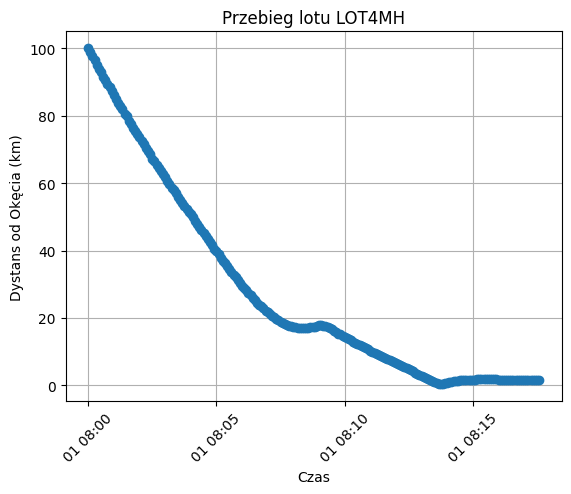

In [80]:
# Filtrowanie danych dla danego lotu
lot_df = master_df[master_df['flight'] == 'LOT4MH']
x = lot_df['distance_km']
y = lot_df['time']

# Sprawdzenie, czy nie ma wartości NaT (błędnych dat)
print(y.isna().sum(), "błędnych wartości w 'time'")

# Tworzenie wykresu
plt.plot(y,x, marker='o')
plt.ylabel('Dystans od Okęcia (km)')
plt.xlabel('Czas')
plt.title('Przebieg lotu LOT4MH')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()


In [70]:
master_df.head(20).to_excel("data_sample.xlsx")

#### Finding unique flights

(array([5663., 1150.,  910.,  704.,  618.,  703.,  696.,  440.,  454.,
         466.,  453.,  446.,  548.,  685.,  292.,  341.,  335.,  420.,
         477.,  823.,  951., 1551.,  940.,  834.,  807., 1252., 1351.,
        1109.,  856.,  489.,  676., 1036., 1037.,  336.,  602.,  550.,
         219.,  141.,  147.,  144.,  146.,  145.,  165.,  195.,  222.,
         620.,  218.,  239.,  247.,  250.,  301.,  344.,  632.,  248.,
         211.,  135.,  117.,  133.,  249.,  244.,  236.,  433.,  380.,
         174.,  433.,   72.,  238.,  239.,   71.,   70.,  248.,   34.,
         200.,  203.,   34.,  203.,   35.,  177.,  170.,    0.,    0.,
         290.,   48.,  166.,    0.,    0.,  278.,   49.,  349.,  157.,
           0.,   41.,  167.,  181.,  169.,    0.,    0.,  169.,  138.,
          90.,    0.,    0.,  157.,    0.,    0.,    0.,    0.,    0.,
         114.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

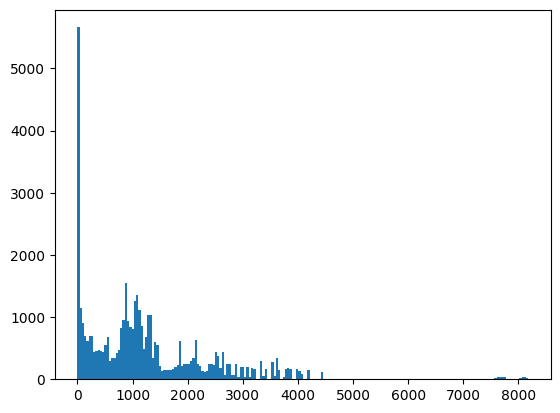

In [16]:
plt.hist(master_df['distance_km'], bins=200)

# TMP

master_df

In [17]:
master_df.head()

,hex,type,flight,r,t,alt_baro,alt_geom,gs,track,baro_rate,...,rr_lat,rr_lon,lastPosition,gpsOkBefore,gpsOkLat,gpsOkLon,distance_km,sec,num_of_iteration,acas_ra
1338,48ae04,adsc,LOT4,SP-LRE,B788,41000,NaN,NaN,73.22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4034.363060,080000,1,NaN
1349,495277,adsc,LOT5N,CS-TSW,B772,37000,NaN,NaN,78.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4417.725667,080000,1,NaN
1358,48ae03,adsc,LOT16M,SP-LRD,B788,39000,NaN,NaN,78.30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4082.922002,080000,1,NaN
1398,48ae26,adsc,LOT6E,SP-LSG,B789,37000,NaN,NaN,78.79,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3742.866412,080000,1,NaN
1777,49514b,adsb_icao,TAP120N,CS-TJK,A21N,34325,35100.0,394.0,25.72,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2252.670741,080000,1,NaN


In [18]:
tmp_df = master_df.copy()

In [19]:
tmp_df['under_100'] = np.where(tmp_df['distance_km']<100.0, 1, 0)
tmp_df['under_20'] = np.where(tmp_df['distance_km']<20.0, 1, 0)
tmp_df['under_5'] = np.where(tmp_df['distance_km']<5.0, 1, 0)
tmp_df['under_1'] = np.where(tmp_df['distance_km']<1.0, 1, 0)

In [20]:
tmp_df[tmp_df['distance_km'].between(1, 10)].sort_values(by='distance_km')

,hex,type,flight,r,t,alt_baro,alt_geom,gs,track,baro_rate,...,gpsOkLat,gpsOkLon,distance_km,sec,num_of_iteration,acas_ra,under_100,under_20,under_5,under_1
3534,48ad10,adsb_icao,LOT27M,SP-LIR,E75S,300,500.0,151.2,295.04,640.0,...,NaN,NaN,1.000476,093430,1132,NaN,1,1,1,0
3352,4b17e5,adsb_icao,SWR1GT,HB-JBH,BCS1,ground,500.0,41.5,331.70,-160.0,...,NaN,NaN,1.001013,081925,234,NaN,1,1,1,0
3576,48af0b,adsb_icao,LOT7VJ,SP-LVL,B38M,ground,NaN,10.2,152.00,0.0,...,NaN,NaN,1.001753,093920,1190,NaN,1,1,1,0
3551,48ad02,adsb_icao,LOT7KG,SP-LIC,E75S,ground,NaN,14.2,NaN,NaN,...,NaN,NaN,1.002277,093445,1135,NaN,1,1,1,0
3610,48ae81,adsb_icao,LOT7HL,SP-LWB,B738,ground,NaN,4.2,NaN,NaN,...,NaN,NaN,1.003023,095620,1394,NaN,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,48ad0d,adsb_icao,LOT4YP,SP-LIN,E75S,6950,7050.0,262.1,153.24,0.0,...,NaN,NaN,9.922711,083335,404,NaN,1,1,0,0
3336,48ad80,adsb_icao,LOT5PG,SP-LMA,E190,6850,6950.0,274.8,140.17,-1280.0,...,NaN,NaN,9.943244,081220,149,NaN,1,1,0,0
3496,471f41,adsb_icao,WZZ42KZ,HA-LVT,A21N,2025,2125.0,131.1,332.26,-704.0,...,NaN,NaN,9.943312,091840,942,NaN,1,1,0,0
3371,738062,adsb_icao,ELY5101,4X-EKR,B738,2025,2150.0,154.1,330.44,-896.0,...,NaN,NaN,9.976004,085540,666,NaN,1,1,0,0


In [21]:
tmp_grb_1 = tmp_df.groupby('sec')['under_1'].sum().reset_index()
tmp_grb_5 = tmp_df.groupby('sec')['under_5'].sum().reset_index()
tmp_grb_20 = tmp_df.groupby('sec')['under_20'].sum().reset_index()
tmp_grb_100 = tmp_df.groupby('sec')['under_100'].sum().reset_index()

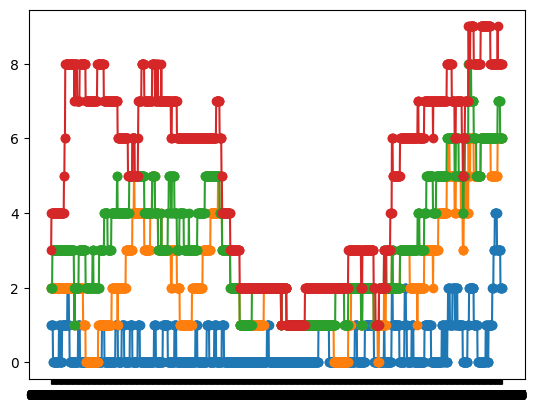

In [22]:
import matplotlib.pyplot as plt

plt.plot(tmp_grb_1['sec'], tmp_grb_1['under_1'], marker='o', linestyle='-')  # Opcjonalne
plt.plot(tmp_grb_5['sec'], tmp_grb_5['under_5'], marker='o', linestyle='-')  # Opcjonalne
plt.plot(tmp_grb_20['sec'], tmp_grb_20['under_20'], marker='o', linestyle='-')  # Opcjonalne
plt.plot(tmp_grb_100['sec'], tmp_grb_100['under_100'], marker='o', linestyle='-')  # Opcjonalne
